In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
from collections import Counter

# --- Config ---
DATA_DIR = 'kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'  # <-- your dataset folder
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(f"Step 1: imports & config done")
print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
print(f"Using device: {DEVICE}")

# --- Folders ---
cancer_folders = set([
    "all_early", "all_pre", "all_pro",
    "brain_glioma", "brain_tumor",
    "breast_malignant",
    "cervix_dyk", "cervix_koc", "cervix_mep", "cervix_pab",
    "kidney_tumor",
    "colon_aca", "lung_aca", "lung_scc",
    "lymph_cll", "lymph_fl", "lymph_mcl",
    "oral_scc"
])
non_cancer_folders = set([
    "all_benign",
    "brain_menin",
    "breast_benign",
    "cervix_sfi",
    "kidney_normal",
    "colon_bnt", "lung_bnt",
    "oral_normal"
])

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

print("Step 2: transforms ready")

# --- Load dataset ---
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
print(f"Step 3: dataset loaded, found classes/folders: {base_dataset.classes}")
print(f"Total images: {len(base_dataset)}")

# --- Custom wrapper to map to binary labels ---
from torch.utils.data import get_worker_info

class BinaryCancerDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        if index == 0:
            print(f"First batch loading! worker={get_worker_info()}")
        img, orig_label = self.base_dataset[index]
        folder_name = self.base_dataset.classes[orig_label]
        if folder_name in cancer_folders:
            binary_label = 1
        elif folder_name in non_cancer_folders:
            binary_label = 0
        else:
            raise ValueError(f"Unknown folder: {folder_name}")
        return img, binary_label

    def __len__(self):
        return len(self.base_dataset)

binary_dataset = BinaryCancerDataset(base_dataset)
print(f"Step 4: binary dataset ready, total samples: {len(binary_dataset)}")

# --- Count class distribution ---
labels = [1 if base_dataset.classes[orig] in cancer_folders else 0 
          for _, orig in base_dataset.samples]
counts = Counter(labels)
print(f"Class distribution: {counts}")
class_counts = [counts[0], counts[1]]  # [non_cancerous, cancerous]
weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
print(f"Using weighted loss: {weights}")

# --- Split ---
train_size = int(0.8 * len(binary_dataset))
test_size = len(binary_dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(binary_dataset, [train_size, test_size])
print(f"Step 5: train/test split done: {train_size} train, {test_size} test")

# --- DataLoader with parallel workers ---
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=0, pin_memory=True)
print("Step 6: DataLoader ready")

# --- Model ---
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CancerCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Step 7: Model, optimizer, loss ready")

# --- Training loop ---
print("\nStep 8: starting training loop...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    t0 = time.time()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss:.4f} - Time: {time.time()-t0:.2f}s "
          f"- GPU mem: {torch.cuda.memory_allocated() / (1024**2):.1f} MB")

print("Training complete.\n")

# --- Evaluation ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(DEVICE, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# --- Report ---
target_names = ['non_cancerous', 'cancerous']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# --- Save model ---
torch.save(model.state_dict(), "binary_cancer_cnn.pth")
print("\n✅ Model saved as binary_cancer_cnn.pth")


Step 1: imports & config done
torch.cuda.is_available(): True
Device count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Step 2: transforms ready
Step 3: dataset loaded, found classes/folders: ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']
Total images: 130002
Step 4: binary dataset ready, total samples: 130002
Class distribution: Counter({1: 90001, 0: 40001})
Using weighted loss: tensor([2.4999e-05, 1.1111e-05])
Step 5: train/test split done: 104001 train, 26001 test
Step 6: DataLoader ready
Step 7: Model, optimizer, loss ready

Step 8: starting training loop...


Epoch 1/10:  52%|█████▏    | 840/1626 [04:07<03:57,  3.31it/s]

First batch loading! worker=None


Epoch 1/10: 100%|██████████| 1626/1626 [08:05<00:00,  3.35it/s]


Epoch [1/10] - Loss: 0.3428 - Time: 485.84s - GPU mem: 145.9 MB


Epoch 2/10:  65%|██████▍   | 1051/1626 [05:15<03:01,  3.17it/s]

First batch loading! worker=None


Epoch 2/10: 100%|██████████| 1626/1626 [08:09<00:00,  3.32it/s]


Epoch [2/10] - Loss: 0.1690 - Time: 489.50s - GPU mem: 145.9 MB


Epoch 3/10:  21%|██▏       | 346/1626 [01:39<06:06,  3.49it/s]

First batch loading! worker=None


Epoch 3/10: 100%|██████████| 1626/1626 [08:01<00:00,  3.37it/s]


Epoch [3/10] - Loss: 0.1210 - Time: 481.84s - GPU mem: 145.9 MB


Epoch 4/10:  86%|████████▌ | 1399/1626 [06:50<01:06,  3.39it/s]

First batch loading! worker=None


Epoch 4/10: 100%|██████████| 1626/1626 [07:56<00:00,  3.41it/s]


Epoch [4/10] - Loss: 0.0967 - Time: 477.00s - GPU mem: 145.9 MB


Epoch 5/10:  21%|██▏       | 346/1626 [01:37<06:15,  3.41it/s]

First batch loading! worker=None


Epoch 5/10: 100%|██████████| 1626/1626 [07:52<00:00,  3.44it/s]


Epoch [5/10] - Loss: 0.0806 - Time: 472.51s - GPU mem: 145.9 MB


Epoch 6/10:  53%|█████▎    | 858/1626 [04:03<03:40,  3.48it/s]

First batch loading! worker=None


Epoch 6/10: 100%|██████████| 1626/1626 [07:49<00:00,  3.47it/s]


Epoch [6/10] - Loss: 0.0664 - Time: 469.22s - GPU mem: 145.9 MB


Epoch 7/10:  93%|█████████▎| 1518/1626 [07:16<00:31,  3.41it/s]

First batch loading! worker=None


Epoch 7/10: 100%|██████████| 1626/1626 [07:48<00:00,  3.47it/s]


Epoch [7/10] - Loss: 0.0541 - Time: 468.62s - GPU mem: 145.9 MB


Epoch 8/10:  40%|████      | 652/1626 [03:03<04:33,  3.56it/s]

First batch loading! worker=None


Epoch 8/10: 100%|██████████| 1626/1626 [07:48<00:00,  3.47it/s]


Epoch [8/10] - Loss: 0.0492 - Time: 468.24s - GPU mem: 145.9 MB


Epoch 9/10:  11%|█▏        | 184/1626 [00:51<06:44,  3.57it/s]

First batch loading! worker=None


Epoch 9/10: 100%|██████████| 1626/1626 [07:46<00:00,  3.49it/s]


Epoch [9/10] - Loss: 0.0458 - Time: 466.22s - GPU mem: 145.9 MB


Epoch 10/10:  51%|█████     | 829/1626 [03:52<03:49,  3.47it/s]

First batch loading! worker=None


Epoch 10/10: 100%|██████████| 1626/1626 [07:44<00:00,  3.50it/s]


Epoch [10/10] - Loss: 0.0393 - Time: 464.54s - GPU mem: 145.9 MB
Training complete.



Testing: 100%|██████████| 407/407 [01:52<00:00,  3.61it/s]


Classification Report:
               precision    recall  f1-score   support

non_cancerous       0.95      0.97      0.96      8131
    cancerous       0.98      0.98      0.98     17870

     accuracy                           0.97     26001
    macro avg       0.97      0.97      0.97     26001
 weighted avg       0.97      0.97      0.97     26001

Confusion Matrix:
[[ 7860   271]
 [  425 17445]]

✅ Model saved as binary_cancer_cnn.pth


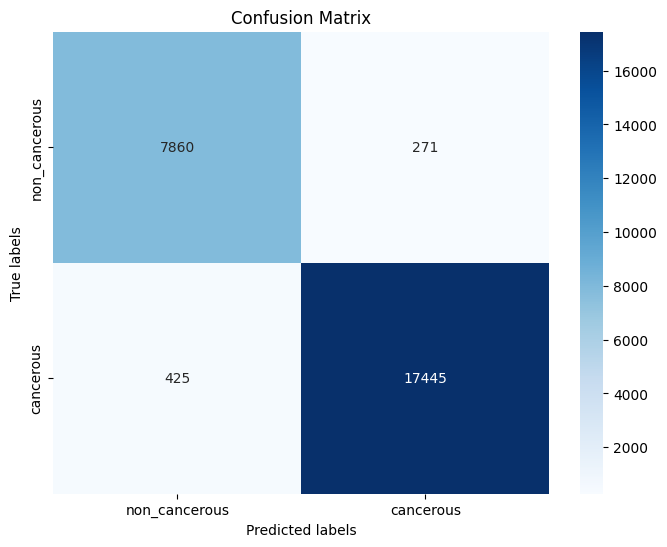

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names= ['non_cancerous', 'cancerous']
# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
